## Dictionary and Imports

In [38]:
# Dictionary of users and passwords registered
speakers = {
    0: 'Arianna',
    1: 'Andre'
}

passwords = {
    0: 'falcon',
    1: 'tiger'
}

In [39]:
import os
import random
import numpy as np
import librosa
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import speech_recognition as sr
import tsfel
import pandas as pd
import webrtcvad

from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

## Audio processing module

This module processes and analyses audio signals for feature extraction, particularly focusing on preprocessing and preparing the data for further analysis. Three functions collectively support audio signal processing workflows in applications.

In [40]:
def preprocess_audio(file_path, low_cutoff=100, high_cutoff=3000):
    """
    Preprocess an audio file by applying a band-pass filter to isolate frequencies
    within the specified range and normalizing the signal.

    Parameters:
    file_path (str): Path to the audio file.
    low_cutoff (float): Lower cutoff frequency for the band-pass filter in Hz. Default is 100 Hz.
    high_cutoff (float): Upper cutoff frequency for the band-pass filter in Hz. Default is 3000 Hz.

    Returns:
    tuple: Filtered audio signal (numpy array) and the sample rate (int).
    """

    signal, sr = librosa.load(file_path, sr=None)      #'sr=None' ensures the original sample rate is preserved.

    # Normalize values between -1 and 1 for uniform processin.
    normalized_signal = librosa.util.normalize(signal)  

    # Design a 5th-order Butterworth band-pass filter.
    nyquist = 0.5 * sr
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(5, [low, high], btype='band')

    filtered_signal = lfilter(b, a, normalized_signal)
    return filtered_signal, sr

def select_test_audio(n):
    """
    Select an audio file from the designated "test" folder. The function can either select
    a file randomly or based on its position in a sorted list of files.

    Parameters:
    n (int): If 0, a random file is selected. If greater than 0, selects the nth file
             (1-based index) from the list of audio files sorted in ascending order.

    Returns:
    str: Full path to the selected audio file.
    """

    test_folder = "./dataset/test" 
    audio_files = [f for f in os.listdir(test_folder) if f.endswith('.wav')]
    audio_files.sort(reverse=True)

    # Raise an error if no audio files are found in the folder.
    if not audio_files:
        raise FileNotFoundError("No audio files found in the 'test' folder.")

    if n == 0:
        selected_file = random.choice(audio_files)
    else:
        if n > len(audio_files):
            raise IndexError(f"The test folder contains only {len(audio_files)} files.")
        
        audio_files.reverse()
        selected_file = audio_files[n - 1]

    # Construct the full path to the selected file.
    file_path = os.path.join(test_folder, selected_file)
    return file_path

def extract_features(file_path):
    """
    Extract MFCC (Mel-frequency cepstral coefficients) and other temporal features
    from an audio file using preprocessing and the TSFEL library.

    Parameters:
    file_path (str): Path to the audio file to be processed.

    Returns:
    tuple, containing:
        - A numpy array of the extracted features.
        - The preprocessed audio signal.
    """

    [y, sr] = preprocess_audio(file_path)

    # Convert the preprocessed signal into a Pandas DataFrame for feature extraction.
    signal_df = pd.DataFrame(y, columns=["Signal"])

    # Get the feature extraction configuration from TSFEL, organized by domain.
    features = tsfel.get_features_by_domain()

    # Extract features from the time series signal using the TSFEL library.
    extracted_features = tsfel.time_series_features_extractor(features, signal_df, sr)
    return extracted_features.to_numpy(), y


## Data preparation module

This module handles the preparation of audio data for training machine learning models. It includes functions to generate file paths for audio files within specific folders, extract features and assign labels to the data based on the speaker's identity. Finally, it combines the features and labels into unified datasets, ready to be used for classification or analysis tasks.

In [41]:
def generate_file_paths(folder_path, extension=[".wav"]):
    """
    Generate a list of absolute file paths for files with specified extensions in a given folder.

    Parameters:
    folder_path (str): The path to the folder containing the files.
    extension (list): A list of file extensions to include (default is [".wav"]).

    Returns:
    list: A list of absolute file paths for matching files.
    """
    
    file_paths = [
        os.path.abspath(os.path.join(folder_path, file))
        for file in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, file)) and os.path.splitext(file)[1].lower() in extension
    ]
    return file_paths

def create_labels_and_features(file_paths, speaker_id):
    """
    Extract features and create labels for a set of audio files.

    Parameters:
    file_paths (list): A list of file paths for the audio files.
    speaker_id (int): The label or identifier for the speaker associated with the audio files.

    Returns:
    tuple: A tuple containing:
        - A numpy array of extracted features for all audio files.
        - A numpy array of labels corresponding to each audio file.
    """

    features = []
    labels = []

    # Loop through each file and extract features and corresponding labels.
    for file_path in file_paths:
        [embedding, y] = extract_features(file_path)  # Extract MFCC features from the audio file.
        features.append(embedding)  
        labels.append(speaker_id) 
    
    return np.array(features), np.array(labels)

# Generate file paths for audio files of different speakers.
arianna_files = generate_file_paths('dataset/registered/arianna')
andre_files = generate_file_paths('dataset/registered/andre') 
others_files = generate_file_paths('dataset/registered/others/')

# Create features and labels for each speaker.
arianna_features, arianna_labels = create_labels_and_features(arianna_files, speaker_id=0)  # Arianna's data.
andre_features, andre_labels = create_labels_and_features(andre_files, speaker_id=1)        # André's data.
others_features, others_labels = create_labels_and_features(others_files, speaker_id=2)     # Others' data.

# Combine features and labels into unified datasets for training.
X_train = np.vstack([arianna_features, andre_features, others_features])    # Combine all features.
y_train = np.hstack([arianna_labels, andre_labels, others_labels])          # Combine all labels.

## Model training

Recognizes who is speaking regardless of content.
Focus on the physical and behavioural properties of the voice.

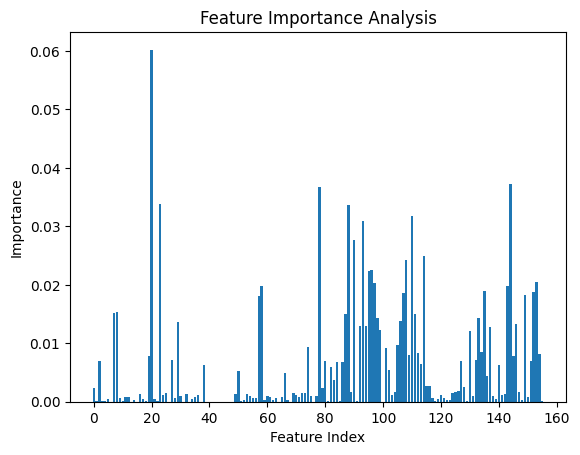

In [50]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    # n_estimators=100: Number of trees in the forest
    # max_depth=10: Maximum depth of each tree to prevent overfitting
    # random_state=42: Ensures reproducibility of results

n_samples, time_steps, n_features = X_train.shape
X_train_flattened = X_train.reshape(n_samples, time_steps * n_features)

model.fit(X_train_flattened, y_train)   # train the model, result: iperplane

## Password recognition module

The system checks that the person is using their own password and not someone else's. The spoken password is transcribed into text and compared with the registered password of the identified user.

In [51]:
def recognize_password(path_test_audio, prediction):
    """
    Recognizes a password from an audio file and checks its similarity to the expected password.

    Parameters:
    - audio_file_path (str): The path to the audio file containing the spoken password.
    - prediction (int): An integer indicating which password to use (0 for 'Falcon', 1 for 'Tiger').

    This function uses the Google Web Speech API to transcribe the spoken password and compares it
    to the correct password using fuzzy string matching. A similarity score of 80% or higher is 
    considered a successful match.
    """

    # Initialize the speech recognizer
    recognizer = sr.Recognizer()
    correct_password = passwords.get(prediction)
    threshold = 80.00

    try:
        with sr.AudioFile(path_test_audio) as source:
            test_audio = recognizer.record(source)

        # Transcribe the audio to text using Google Web Speech API
        recognized_text = recognizer.recognize_google(test_audio)
        print(f"Recognized text: {recognized_text}")

        # Calculate similarity between the recognized text and the correct password
        similarity = fuzz.ratio(recognized_text.lower(), correct_password.lower())

        # Confronta la parola riconosciuta con la password
        if similarity >= threshold:
            print("Password recognized successfully!")
            print("Access allowed!")
        else:
            print("Password does not match...")
            print("Access denied.")
    
    except sr.UnknownValueError:
        print("Sorry, could not understand the audio.")
    except sr.RequestError as e:
        print(f"Error with the speech recognition service: {e}")

## Speaker recognition 

In [52]:
# Set confidence threshold for speaker recognition
threshold = 0.80

# Iterate through test audio files
for i in range(1, 22): 
    path_test_audio = select_test_audio(i)
    
    # Extract MFCC features and the processed audio from the test file
    test_embedding, test_audio = extract_features(path_test_audio)
   
    # Reshape the MFCC features to match model input shape
    test_embedding_reshaped = test_embedding.reshape(1, -1)
    
    # Predict probabilities and confidence
    probabilities = model.predict_proba(test_embedding_reshaped)[0]
    prediction = np.argmax(probabilities)       # Speaker predicted
    confidence = probabilities[prediction]      # Confidence
    
    print(f"Testing audio: {path_test_audio}")

    # Map the predicted index to the speaker's name
    if prediction==0 or prediction==1:
        if confidence < threshold:
            print(f"Confidence ({confidence}) is below the threshold.\n")
            print(f"The speaker is detected as one not registered. \n")
        else:
            predicted_speaker = speakers.get(prediction)
            print(f"Speaker {predicted_speaker} recognized! With confidence {confidence}\n")

            recognize_password(path_test_audio, prediction)
    else:
        print(f"The speaker is detected as one not registered. \n")

Testing audio: ./dataset/test/andre_pw1.wav
Speaker Andre recognized! With confidence 0.82

Recognized text: tiger
Password recognized successfully!
Access allowed!


Testing audio: ./dataset/test/andre_random.wav
Speaker Andre recognized! With confidence 0.88

Recognized text: I'm lost
Password does not match...
Access denied.


Testing audio: ./dataset/test/andre_random2.wav
Speaker Andre recognized! With confidence 0.92

Recognized text: yeah this is the last one I think it's done
Password does not match...
Access denied.


Testing audio: ./dataset/test/arianna_pw1.wav
Speaker Arianna recognized! With confidence 0.94

Recognized text: falcon
Password recognized successfully!
Access allowed!


Testing audio: ./dataset/test/arianna_pw2.wav
Speaker Arianna recognized! With confidence 0.97

Recognized text: falcon
Password recognized successfully!
Access allowed!


Testing audio: ./dataset/test/arianna_random.wav
Speaker Arianna recognized! With confidence 0.92

Recognized text: red cabin is for emergency
Password does not match...
Access denied.


Testing audio: ./dataset/test/bird1.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/bird2.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/cat1.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/cat2.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/dog1.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/dog2.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/dog3.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/luca_random2.wav
Confidence (0.53) is below the threshold.

The speaker is detected as one not registered. 



Testing audio: ./dataset/test/others1.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/others2.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/others3.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/others4.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/others5.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/others6.wav
The speaker is detected as one not registered. 



Testing audio: ./dataset/test/pedro_falcon.wav
Confidence (0.53) is below the threshold.

The speaker is detected as one not registered. 

